## Which EPL teams are getting better at progressive passes?

### Imports & Fonts

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
import numpy as np

from mplsoccer import Pitch

from PIL import Image
import urllib
import os

In [2]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if (y.split(".")[-1] == "ttf") or (y.split(".")[-1] == "otf"):
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")
plt.rcParams['font.family'] = 'DM Sans'

### Reading the data

In [9]:
data = pd.read_csv('data/prog_passes_01172023.csv', index_col=0)
team_map = pd.read_csv('../01022023/data/team_mapping.csv', encoding='utf-8')

In [10]:
data = pd.merge(data, team_map[['team_id', 'fotmob_id']], how='left', on='team_id')
data.head()

,team_name,team_id,pass_area,season,succ,unsucc,succ_rate_22,succ_rate_21,change_in_succ,fotmob_id
0,Arsenal,13,Attacking-third,2022_2023,324,277,0.539101,0.504257,0.034844,9825
1,Arsenal,13,Defensive-third,2022_2023,95,201,0.320946,0.290936,0.030010,9825
2,Arsenal,13,Middle-third,2022_2023,289,190,0.603340,0.508353,0.094987,9825
3,Aston Villa,24,Attacking-third,2022_2023,189,285,0.398734,0.437916,-0.039182,10252
4,Aston Villa,24,Defensive-third,2022_2023,141,319,0.306522,0.324147,-0.017625,10252


### The Viz

In [14]:
color_map = [
    '#e7deda',
    '#d8ccc7',
    '#c8bbb5',
    '#b9aaa3',
    '#ab9992',
    '#9c8980',
    '#8d7970',
    '#7f695f',
    '#715a4f',
    '#634b40',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', color_map, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)
norm = mcolors.Normalize(vmin=data['succ_rate_22'].min(),vmax=data['succ_rate_22'].max())

Sort data

In [20]:
data['pass_area'] = pd.Categorical(data['pass_area'], ['Defensive-third', 'Middle-third', 'Attacking-third'])
data = data.sort_values(by=['team_name','pass_area']).reset_index(drop=True)

An example for a single team.

Text(50, 116, 'Overall prog. pass success rate: 41.0%')

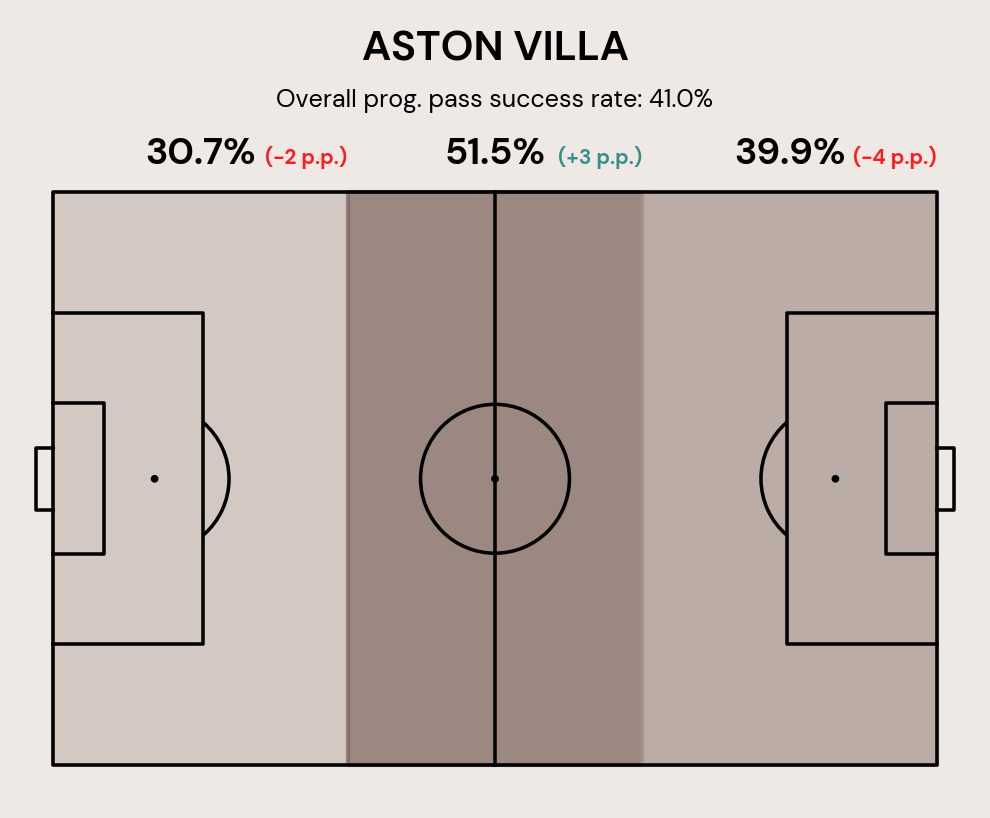

In [57]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = plt.subplot(111)
pitch = Pitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=.85,
    line_color='black',
    half=False
)
pitch.draw(ax = ax)

aux_data = data[data['team_id'] == 24].reset_index(drop=True)

pitch_divisions = [0, 100/3, 2*(100/3), 100]
for index, x in enumerate(pitch_divisions[:-1]):
    ax.fill_between(
        x=[pitch_divisions[index], pitch_divisions[index + 1]],
        y1=0, y2=100,
        color=soc_cm(norm(aux_data['succ_rate_22'].iloc[index])),
        zorder=-1, alpha=0.75
    )
    mid_point = pitch_divisions[index] + (100/3)/2
    ax.annotate(
        xy=(mid_point, 105),
        text=f"{aux_data['succ_rate_22'].iloc[index]:.1%}",
        annotation_clip=False, ha='center', weight='bold',
        size=9
    )
    if ~(aux_data['change_in_succ'][index] is None):
        if aux_data['change_in_succ'].iloc[index]*100 > 0:
            aux_color = '#368f8b'
            aux_text = '+'
        else:
            aux_color = '#ff1b1c'
            aux_text = ''
        ax.annotate(
            xy=(pitch_divisions[index + 1], 105),
            text=f"({aux_text}{aux_data['change_in_succ'].iloc[index]*100:.0f} p.p.)",
            annotation_clip=False, ha='right',
            size=5, weight='bold', color=aux_color
        ) 

ax.annotate(
    xy=(50,125),
    text=f"{aux_data['team_name'].iloc[0].upper()}",
    size=10,
    color='black',
    ha='center',
    va='center',
    weight='bold',
    annotation_clip=False
)
overall_succ = aux_data['succ'].sum()/(aux_data['succ'].sum() + aux_data['unsucc'].sum())
ax.annotate(
    xy=(50,116),
    text=f"Overall prog. pass success rate: {overall_succ:.1%}",
    size=6,
    color='black',
    ha='center',
    va='center',
    annotation_clip=False
)

Turning it into a function.

In [95]:
def plot_prog_pass_succ(ax, team_name):
    pitch = Pitch(
        pitch_type='opta',
        goal_type='box',
        linewidth=.65,
        line_color='black',
        half=False
    )
    pitch.draw(ax = ax)

    aux_data = data[data['team_name'] == team_name].reset_index(drop=True)

    pitch_divisions = [0, 100/3, 2*(100/3), 100]
    for index, x in enumerate(pitch_divisions[:-1]):
        ax.fill_between(
            x=[pitch_divisions[index], pitch_divisions[index + 1]],
            y1=0, y2=100,
            color=soc_cm(norm(aux_data['succ_rate_22'].iloc[index])),
            zorder=-1, alpha=0.75
        )
        mid_point = pitch_divisions[index] + (100/3)/2
        text_ = ax.annotate(
            xy=(mid_point, 85),
            text=f"{aux_data['succ_rate_22'].iloc[index]:.1%}",
            annotation_clip=False, ha='center', weight='bold',
            size=11, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=1.5, alpha=0.75)
        )
        text_.set_path_effects(
                [path_effects.Stroke(linewidth=1.75, foreground="white"), 
                path_effects.Normal()]
            )
        if ~(np.isnan(aux_data['change_in_succ'][index])):
            if aux_data['change_in_succ'].iloc[index]*100 > 0:
                aux_color = '#368f8b'
                aux_text = '+'
            else:
                aux_color = '#ff1b1c'
                aux_text = ''
            ax.annotate(
                xy=(mid_point, 105),
                text=f"{aux_text}{aux_data['change_in_succ'].iloc[index]*100:.0f} p.p.",
                annotation_clip=False, ha='center',
                size=9.5, weight='bold', color=aux_color
            ) 

    ax.annotate(
        xy=(50,125),
        text=f"{aux_data['team_name'].iloc[0].upper()}",
        size=11.5,
        color='black',
        ha='center',
        va='center',
        weight='bold',
        annotation_clip=False
    )
    overall_succ = aux_data['succ'].sum()/(aux_data['succ'].sum() + aux_data['unsucc'].sum())
    ax.annotate(
        xy=(50,116),
        text=f"Overall prog. pass success rate: {overall_succ:.1%}",
        size=7,
        color='black',
        ha='center',
        va='center',
        annotation_clip=False
    )

    return ax

### The Final Visual

In [71]:
order_teams = data[['team_name', 'fotmob_id']].drop_duplicates()

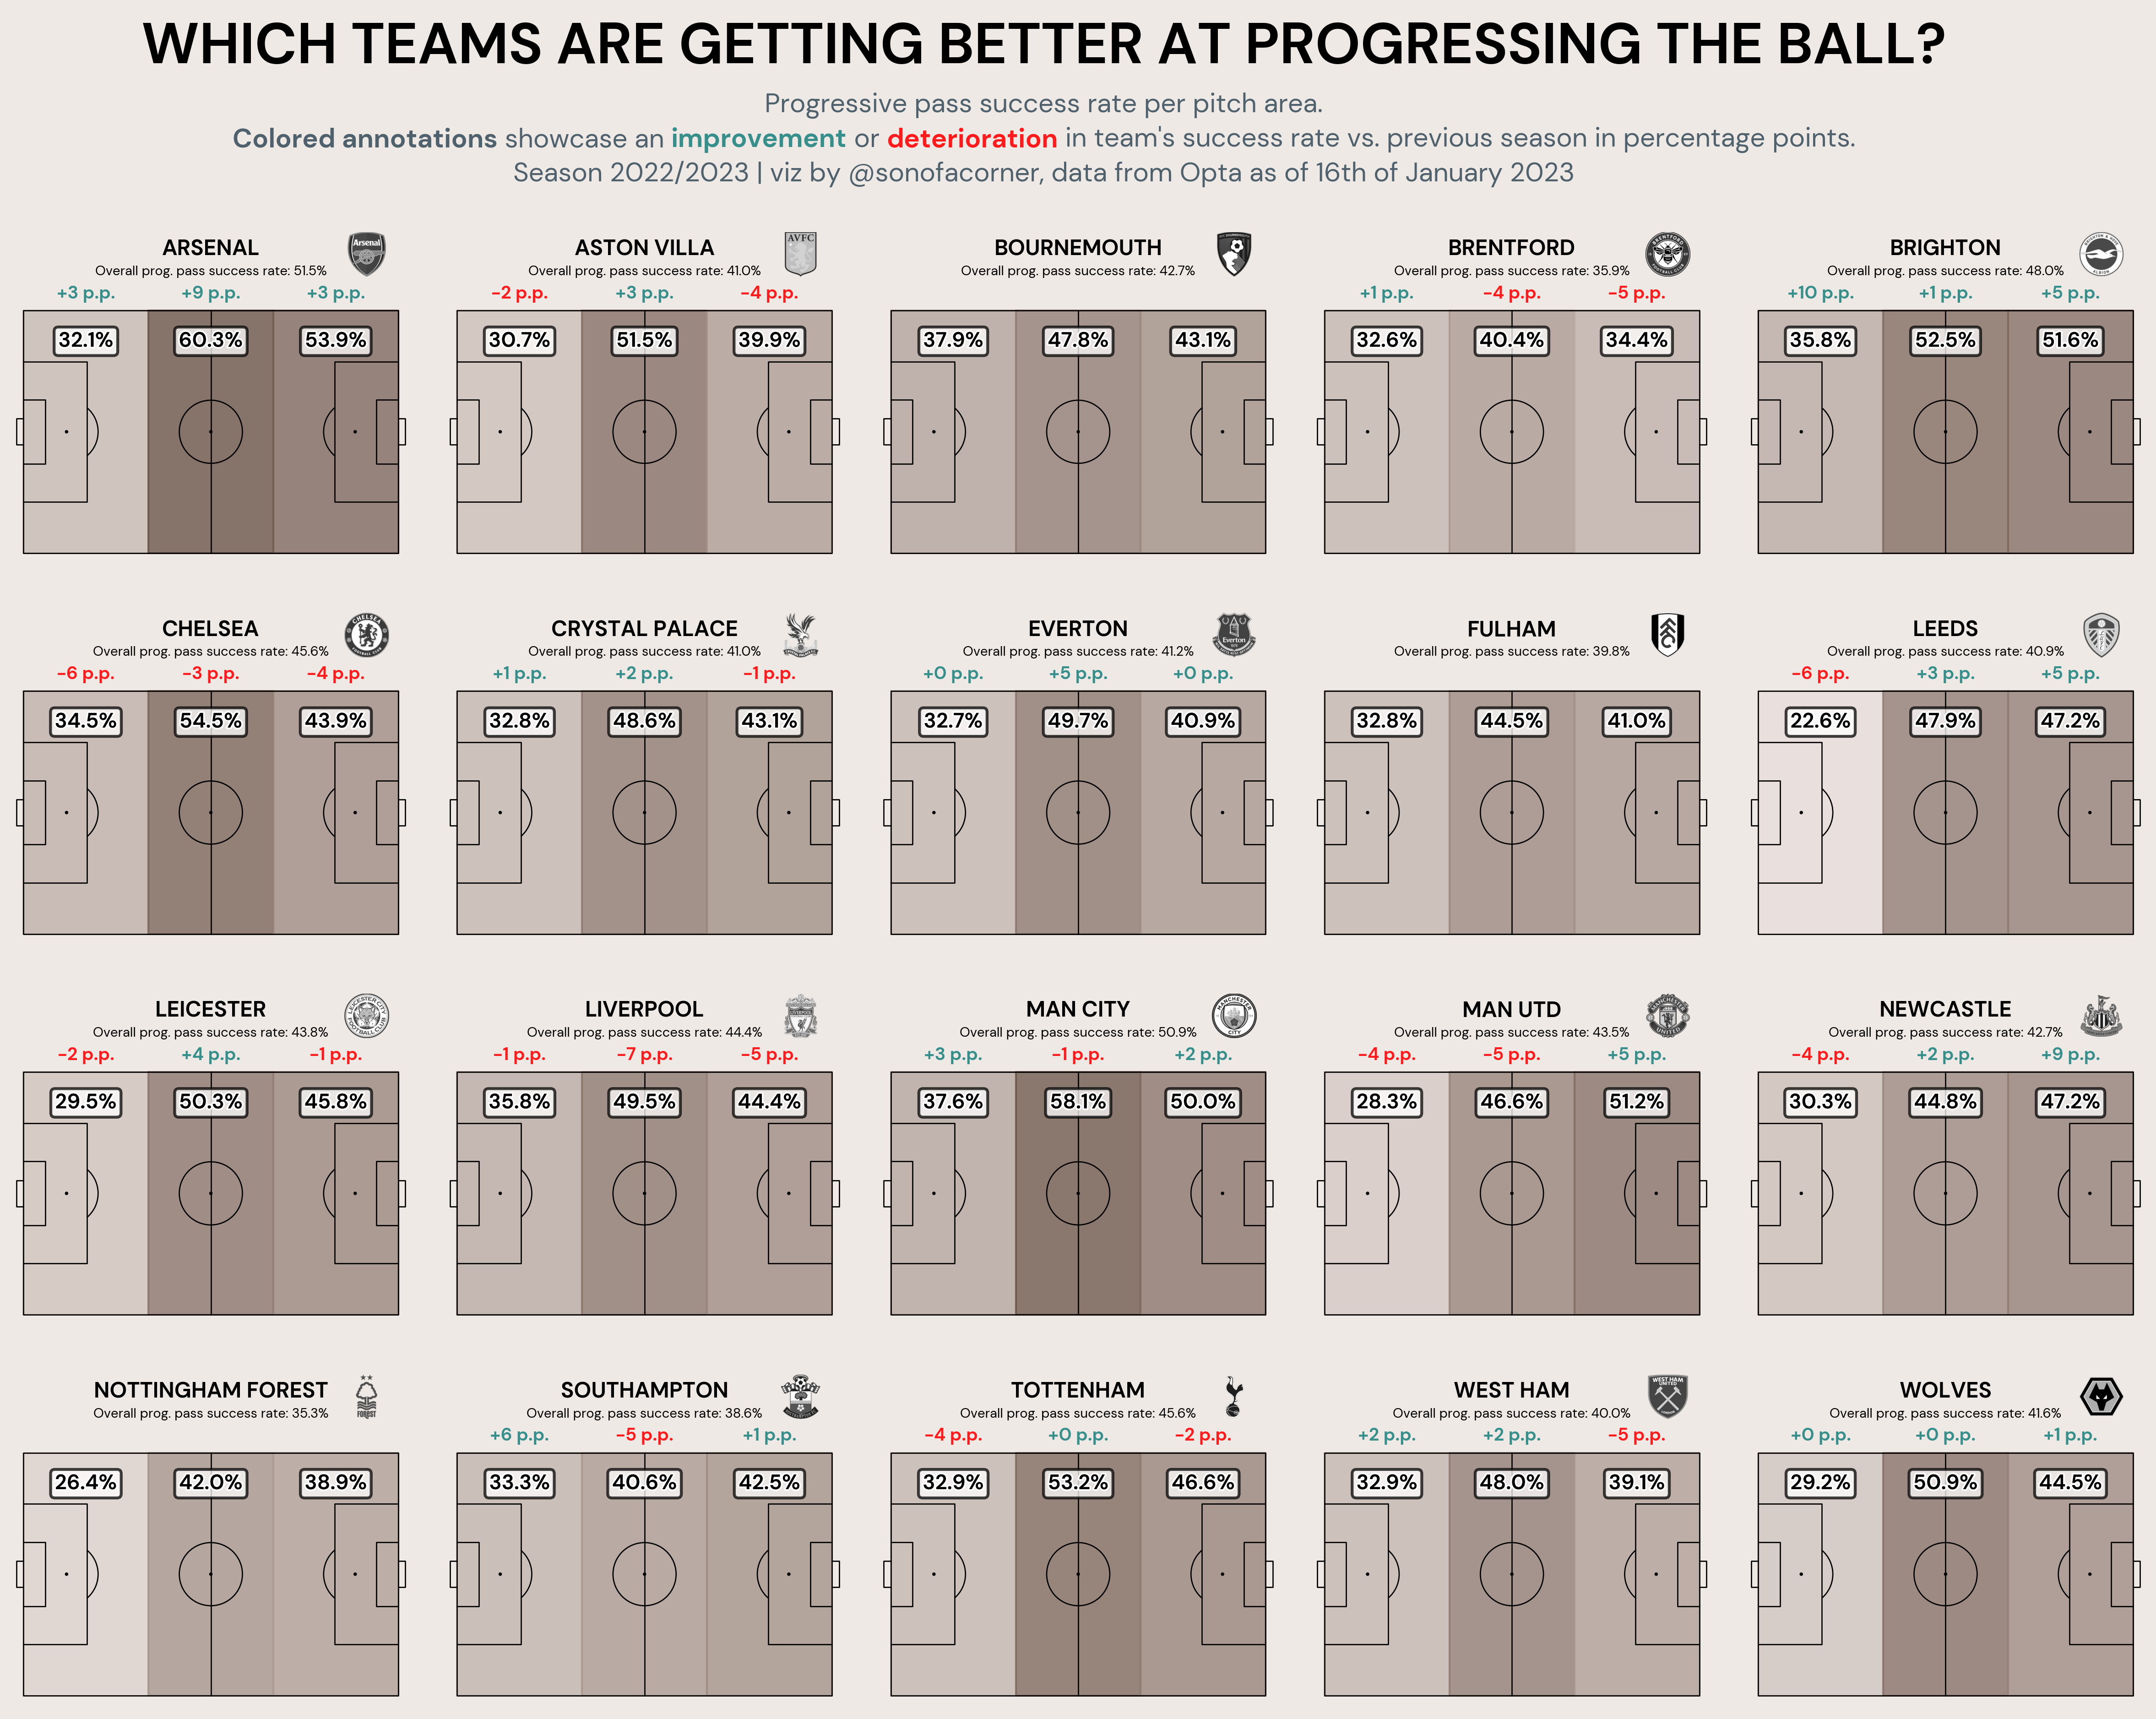

In [96]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(20,18), dpi=300)
axs = np.array(axs)
for index, ax in enumerate(axs.reshape(-1)):
    plot_prog_pass_succ(ax, order_teams['team_name'].iloc[index])

plt.subplots_adjust(wspace=.1, hspace=-.5)
# We add the logos once we've reshaped the figure
for index, ax in enumerate(axs.reshape(-1)):
    # -- Transformation functions
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((85,72))
    ax_size = 0.018
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{order_teams["fotmob_id"].iloc[index]:.0f}.png')).convert('LA')
    image_ax.imshow(club_icon)
    image_ax.axis('off')

fig_text(
    x = 0.5, y = .87, 
    s = "WHICH TEAMS ARE GETTING BETTER AT PROGRESSING THE BALL?",
    va = "bottom", ha = "center",
    fontsize = 30, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.5, y = .825, 
    s = "Progressive pass success rate per pitch area.\n<Colored annotations> showcase an <improvement> or <deterioration> in team's success rate vs. previous season in percentage points.\nSeason 2022/2023 | viz by @sonofacorner, data from Opta as of 16th of January 2023",
    highlight_textprops=[{"weight": "bold"}, {"weight": "bold", 'color':'#368f8b'}, {"weight": "bold", 'color':'#ff1b1c'}],
	va = "bottom", ha = "center",
	fontsize = 14, color = "#4E616C", font="DM Sans", textalign='center'
)

plt.savefig(
	"figures/01172023_epl_progression.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/01172023_epl_progression_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)